In [30]:
!pip install stellargraph
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

import pickle
import os

import pandas as pd
import numpy as np

In [31]:
with open("../input/gcnn-test/graphs.txt", "rb") as fp:   # Unpickling ../input/egg-new/26-0.2/graphs.txt
    graphs = pickle.load(fp)
    
with open("../input/gcnn-test/labels.txt", "rb") as fp:   # Unpickling
    labels = pickle.load(fp)

In [32]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 25, Edges: 75

 Node types:
  default: [25]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [75]
        Weights: range=[0.55206, 0.961213], mean=0.715728, std=0.0994493
        Features: none


In [33]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,906.0,906.0
mean,25.0,85.9
std,0.0,44.1
min,25.0,10.0
25%,25.0,51.2
50%,25.0,79.0
75%,25.0,114.0
max,25.0,249.0


In [34]:
labels.value_counts().to_frame()

,label
1,462
0,444


In [35]:
graph_labels = pd.get_dummies(labels, drop_first=True)

In [36]:
training_graphs, pred_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.90, test_size=None, stratify=graph_labels, random_state=6,
)

train_graphs, test_graphs = model_selection.train_test_split(
    training_graphs, train_size=0.85, test_size=None, stratify=training_graphs, random_state=6,
    
)

In [37]:
print('Test size:', len(pred_graphs.values))
print('Validation size:', len(test_graphs.values))
print('Training size:',len(train_graphs.values))

Test size: 91
Validation size: 123
Training size: 692


In [38]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=25,
    symmetric_normalization=True,
    weighted = True
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=25,
    symmetric_normalization=True,
    weighted = True
)

pred_gen = gen.flow(
    list(pred_graphs.index - 1),
    targets=pred_graphs.values,
    batch_size=1,
    symmetric_normalization=True,
    weighted = True
)

In [39]:
def create_model(graphs, k, layer_sizes, activations1, activations2, dense_layers, dense_units, optimizer, conv, dropout_amount, dropout=None):
    generator = PaddedGraphGenerator(graphs=graphs)
    k = k  # the number of rows for the output tensor
    layer_sizes = layer_sizes

    dgcnn_model = DeepGraphCNN(
        layer_sizes= layer_sizes,
        activations= activations1,
        k=k,
        bias=False,
        generator=generator,
    )
    x_inp, x_out = dgcnn_model.in_out_tensors()
    
    if(conv):
        x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
    
    x_out = Flatten()(x_out)


    for i in range(dense_layers):
        if((i % dropout_amount) == 0):
            if(dropout):
                x_out = Dropout(rate=dropout)(x_out)
                
        if(dense_units < 32):
            dense_units = 32
    
        x_out = Dense(units=dense_units, activation= activations2)(x_out)
        dense_units /= 2

    
    predictions = Dense(units=1, activation="sigmoid")(x_out)
    
    model = Model(inputs=x_inp, outputs=predictions)
    
    model.summary()
    return model

In [40]:
model = create_model(graphs, 25, [16,32], ['tanh', 'tanh'], 'relu', 1, 32, 'optimizers.Adagrad()', 0, 5, None)
model.compile(
    optimizer=optimizers.Adam(), loss=binary_crossentropy, metrics=["acc"],
)

# checkpoint
filepath="weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
    train_gen, epochs=1000, verbose=1, validation_data=test_gen, shuffle=False
)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, None, 3)      0           input_7[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
graph_convolution_4 (GraphConvo (None, None, 16)     48          dropout_4[0][0]                  
                                                                 input_9[0][0]              

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/sort_pooling_2/map/while/gradients/model_2/sort_pooling_2/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/sort_pooling_2/map/while/gradients/model_2/sort_pooling_2/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/sort_pooling_2/map/while/gradients/model_2/sort_pooling_2/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


28/28 [==============================] - 2s 24ms/step - loss: 0.7133 - acc: 0.5077 - val_loss: 0.7140 - val_acc: 0.4797
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.7052 - acc: 0.4976 - val_loss: 0.6915 - val_acc: 0.5122
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6927 - acc: 0.5137 - val_loss: 0.6872 - val_acc: 0.5285
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.6860 - acc: 0.5432 - val_loss: 0.6870 - val_acc: 0.5285
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.6838 - acc: 0.5427 - val_loss: 0.6865 - val_acc: 0.5285
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.6826 - acc: 0.5471 - val_loss: 0.6883 - val_acc: 0.5285
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.6824 - acc: 0.5486 - val_loss: 0.6879 - val_acc: 0.5285
Epoch 8/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.6814 

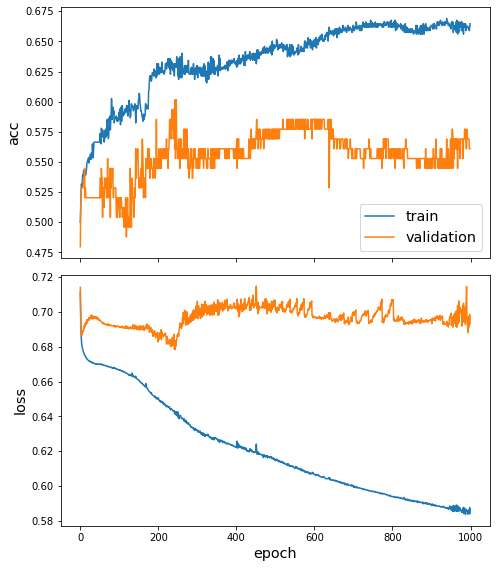

In [41]:
sg.utils.plot_history(history)

In [42]:
test_metrics = model.evaluate(pred_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

91/91 [==============================] - 0s 2ms/step - loss: 0.6286 - acc: 0.6484

Test Set Metrics:
	loss: 0.6286
	acc: 0.6484


In [43]:
def custom_predict_eval(pred_gen, pred_graphs, values, verbose=0):
    test_metrics = model.evaluate(pred_gen, verbose=0)
    print("Test Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))
        
    pred_values = model.predict(pred_gen)
    print('=====================\nPrediction size:', len(pred_values))
    print('\nOutput Evaluations:')
        
    for j in range(len(values[0])):
        x = 0
        total_errors = 0
        print('Evaluation range: ', values[0][j], '-', values[1][j], ' and ', values[2][j], '-', values[3][j] )
        for i in range(len(pred_values)):
            if(pred_values[i] >= values[0][j] and pred_values[i] < values[1][j] or pred_values[i] > values[2][j] and pred_values[i] <= values[3][j]):
                x+=1
                error = abs(pred_graphs.values[i] - pred_values[i].round(0))
                total_errors += error
                if(verbose):
                    print('Predicted: ', pred_values[i], '\tClass: ', pred_graphs.values[i], '\tError: ', (error>0))
        if(x!=0):            
            print('Total subjects:', x, '-', round((x/len(pred_values)),2), '%', ' | Total errors:', total_errors[0], ' | Acc:', 1-(total_errors/x), '\n')

In [44]:
values = [[0.45, 0.00], [0.5, 0.45], [0.5, 0.55], [0.55, 1.00]]
custom_predict_eval(pred_gen, pred_graphs, values=values)

Test Set Metrics:
	loss: 0.6286
	acc: 0.6484
Prediction size: 91

Output Evaluations:
Evaluation range:  0.45 - 0.5  and  0.5 - 0.55
Total subjects: 20 - 0.22 %  | Total errors: 8.0  | Acc: [0.6] 

Evaluation range:  0.0 - 0.45  and  0.55 - 1.0
Total subjects: 71 - 0.78 %  | Total errors: 24.0  | Acc: [0.6619718] 



In [45]:
values = [[0.45, 0.2, 0.00], [0.5, 0.45, 0.2], [0.5, 0.55, 0.8], [0.55, 0.8, 1.00]]
custom_predict_eval(pred_gen, pred_graphs, values)

Test Set Metrics:
	loss: 0.6286
	acc: 0.6484
Prediction size: 91

Output Evaluations:
Evaluation range:  0.45 - 0.5  and  0.5 - 0.55
Total subjects: 20 - 0.22 %  | Total errors: 8.0  | Acc: [0.6] 

Evaluation range:  0.2 - 0.45  and  0.55 - 0.8
Total subjects: 55 - 0.6 %  | Total errors: 22.0  | Acc: [0.6] 

Evaluation range:  0.0 - 0.2  and  0.8 - 1.0
Total subjects: 16 - 0.18 %  | Total errors: 2.0  | Acc: [0.875] 



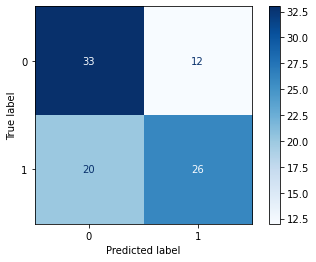

In [46]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_test2 = model.predict(pred_gen)


y_test = [1 * (x[0]>=0.5) for x in y_test2]


conf = confusion_matrix(pred_graphs.values, y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=np.unique(labels))

disp = disp.plot(cmap=plt.cm.Blues, xticks_rotation='0')
plt.show()

In [47]:
TP = conf[1][1]
TN = conf[0][0]
FP = conf[0][1]
FN = conf[1][0]
conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
print('accuracy:', round(conf_accuracy,4))
conf_specificity = (TN / float(TN + FP))
print('specificity:', round(conf_specificity,4))
conf_sensitivity = (TP / float(TP + FN))
print('sensitivity:', round(conf_sensitivity,4))
conf_precision = (TN / float(TN + FP))
print('precision:', round(conf_precision,4))

accuracy: 0.6484
specificity: 0.7333
sensitivity: 0.5652
precision: 0.7333
